<img src='https://storage.googleapis.com/kaggle-datasets-images/228/482/a520351269b547c89afe790820a1087e/dataset-cover.jpeg'>
* ref : kaggle  : https://www.kaggle.com/uciml/pima-indians-diabetes-database
    
    

## Pima Indians Diabetes Database
* Predict the onset of diabetes based on diagnostic measures
* UCI Machine Learning - updated 5 years ago (Version 1)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, precision_score , recall_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.preprocessing import Binarizer

import warnings
warnings.filterwarnings(action='ignore')

sns.set()

# 데이터 로드

In [3]:
df = pd.read_csv("./kaggle/pima/diabetes.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.shape

(768, 9)

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


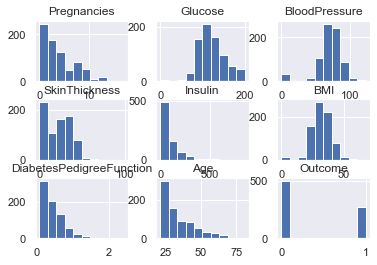

In [ ]:
sns.set()
df.hist()
plt.show()

## 우선 점수부터 보자
---------------------------------------
* 1. str X  
* 2. nan

In [ ]:
y = df['Outcome']
X = df.drop('Outcome', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1414,shuffle=False)
#----------------------------------------------------------------------------------------------
y = df['Outcome']
X = df.drop('Outcome', axis=1)
#----------------------------------------------------------------------------------------------
model = RandomForestClassifier(n_estimators=500,random_state=1414)  #0.7597402597402597
#----------------------------------------------------------------------------------------------
model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy_score(y_test, pred)

0.7597402597402597

# 공통함수 

In [ ]:
def my_eval(y_val, pred, proba, th):  #avg='binary'
        accuracy = accuracy_score(y_val, pred)
        precision = precision_score(y_val, pred)
        recall = recall_score(y_val, pred)
        f1 = f1_score(y_val, pred)
        matrix = confusion_matrix(y_val, pred)
        print(f'정확도{accuracy:.4f} 정밀도:{precision:.4f} 재현률:{recall:.4f} f1:{f1:.4f}')
        print("오차행렬\n", matrix)
        print(type(pred))
        # cls_report = classification_report(y_val, pred)

        # --------------- 양성 평가를 위한 차트 : precision_recall_curv() -------------------    
        # plot_precision_recall_curve(model, 문제지2, 정답지2)
        precisions, recalls, ths = precision_recall_curve(y_val, proba[:, 1])
        plt.title("precision recall curv %0.2f %0.4f"%(th,f1))
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("threadhold")
        plt.ylabel("value")
        plt.plot(ths, precisions[:ths.shape[0]], "b", label="precision")
        plt.plot(ths, recalls[:ths.shape[0]], "r", linestyle='--', label="recall")
        plt.grid()
        plt.legend()
        plt.show()
        
        
        # --------------- 양성 평가를 위한 차트 : roc_auc_score(), roc_curve() -------------------
        auc_score = roc_auc_score(y_val, proba[:, 1])

        fprs, tprs, ths = roc_curve(y_val, proba[:, 1])
        plt.title("roc curv %0.4f" % auc_score)
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("FPR(1-specificity)")
        plt.ylabel("TPR")
        plt.grid()
        plt.plot(fprs, tprs, "b")
        plt.plot([0, 1], [0, 1], '--', color='black')
        plt.show()


def split_fit_score(X, y, model=None, test_size=0.2, th_list=None):
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size,random_state=1414,shuffle=False)

        model.fit(X_train, y_train)
        pred = model.predict(X_test)                                        #[0  1]              th:0.5
        proba = model.predict_proba(X_test)                                 #[[.7 >.3] [.4  <.6]]  --> [0  1]
        
        # ------------------ proba : 양성 점수 측정을 위한 예측 확률값 ---------------
        # proba 리턴값 : ndarray of shape (n_samples, n_classes)  150*3
        # [
        #     [0.4 0.6]  --> 1
        #     [0.7 0.3]  --> 0
        #     [0.42 0.58] -> 1
        # ]
        
        if th_list == None:
            #------------------방법1 ) 임계치 0.5(기본값)으로 점수 출력 ---------------
            binz = Binarizer(threshold=0.5)                              # th:0.5
            pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))    # [[.7 >.3] [.4  <.6]]  --> [0  1]
            my_eval(y_test, pred_binz, proba, 0.5)                        # 점수def호출
 
        else:
            # ----------------방법2) 임계치 조정해가면서 최적의 점수 찾기---------------
            # (24 양성인데 틀리게예측) --> 임계치 낮춘다 == 양성학습데이터늘린다  == 양성점수를 올린다 
            th_list = [0, 0.35 , 0.38, 0.42, 0.45, 0.5, 1]
            for th in th_list:
                    binz = Binarizer(threshold=th)                              # [[.7 .3] [.4  .6]]   th:0.2
                    pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))   # [  th<.3] [  th<.6]]  --> [1 1]
                    print(th)
                    my_eval(y_test, pred_binz, proba, th)                       #점수def호출

## EDA & Engineering
* 이상치 데이터 : 0 
* 왜도(skew) : 정규분포화, 표준화

In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']

In [ ]:
#df[Glucose==0][Glucose]
print(df[df['Glucose']==0]['Glucose'].count(), df[df['Glucose']!=0]['Glucose'].count())

5 763


In [ ]:
for COL in zero_cols:
    print(COL, df[df[COL]==0][COL].count()/df.shape[0]*100, df[df[COL]!=0][COL].count()/df.shape[0]*100) 

Glucose 0.6510416666666667 99.34895833333334
BloodPressure 4.557291666666666 95.44270833333334
SkinThickness 29.557291666666668 70.44270833333334
Insulin 48.69791666666667 51.302083333333336
BMI 1.4322916666666665 98.56770833333334


####  zero_cols : (0/1   &  나이구간별) 평균 --> 0 채우기

In [ ]:
df['BloodPressure'].mean()

69.10546875

In [ ]:
df['Age'].describe() 

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64

In [ ]:
df['Age'].describe() 
#min : 21 ~ max : 81   --> 20 30 40 50 60 70 80 
# df['Age_band'] = df['Age']//20

df['Age_band'] = pd.cut(df['Age'], bins=[0,20,24,29,41,82,150],labels=[0,1,2,3,4,5] )
df[['Age','Age_band']].head() 
df['Age_band'].unique()

[4, 3, 1, 2]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

In [ ]:
# select Age_band, avg(BloodPressure) from emp group by Age_band;
# df[조건].groupby()[컬럼]  Glucose
df[df['BloodPressure']>0].groupby(['Outcome','Age_band'])['BloodPressure'].mean()

Outcome  Age_band
0        0                 NaN
         1           66.839779
         2           70.203390
         3           73.574257
         4           77.518519
         5                 NaN
1        0                 NaN
         1           71.586207
         2           71.250000
         3           74.149425
         4           79.931818
         5                 NaN
Name: BloodPressure, dtype: float64

In [ ]:
for COL in zero_cols:
    print(COL,  df[df[COL]>0].groupby(['Outcome','Age_band'])[COL].mean())
    print("---"*10)

Glucose Outcome  Age_band
0        0                  NaN
         1           107.594595
         2           107.451613
         3           113.133333
         4           119.060241
         5                  NaN
1        0                  NaN
         1           141.064516
         2           140.396226
         3           143.430108
         4           142.741573
         5                  NaN
Name: Glucose, dtype: float64
------------------------------
BloodPressure Outcome  Age_band
0        0                 NaN
         1           66.839779
         2           70.203390
         3           73.574257
         4           77.518519
         5                 NaN
1        0                 NaN
         1           71.586207
         2           71.250000
         3           74.149425
         4           79.931818
         5                 NaN
Name: BloodPressure, dtype: float64
------------------------------
SkinThickness Outcome  Age_band
0        0                

### 이상값(0) 채우기
* Insulin        : Outcome  Age_band
* BloodPressure  : Outcome  Age_band
* Glucose        : Outcome  Age_band
---
* BMI           : Outcome
* SkinThickness : Outcome



In [ ]:
df[zero_cols] = df[zero_cols].replace(0, np.nan)
# df.fillna(  df[zero_cols].transpose( _____ )   )
# df.isna().sum()

In [ ]:
df["Insulin"]       = df["Insulin"].fillna(df.groupby(by=["Outcome","Age_band"])["Insulin"].transform('mean'))
df["BloodPressure"] = df["BloodPressure"].fillna(df.groupby(by=["Outcome","Age_band"])["BloodPressure"].transform('mean'))
df["Glucose"]       = df["Glucose"].fillna(df.groupby(by=["Outcome","Age_band"])["Glucose"].transform('mean'))

df["BMI"]           = df["BMI"].fillna(df.groupby(by="Outcome")["BMI"].transform('mean'))
df["SkinThickness"] = df["SkinThickness"].fillna(df.groupby(by="Outcome")["SkinThickness"].transform('mean'))

In [ ]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Age_band                    0
dtype: int64

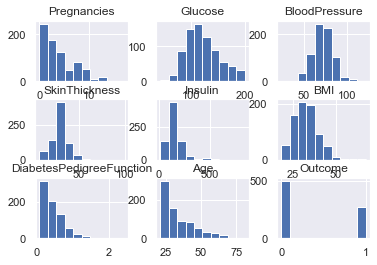

In [ ]:
df.hist()
plt.show()

## 2차 점수 확인 : 스케일링

## 스케일링 : 정규화, 단위맞추기

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [ ]:
# mm = StandardScaler()
# mm.fit(문제지)                       #비율계산
# scaler_문제지 = mm.transform(문제지)  #계산반영해
# split_fit_score(scaler_문제지, 정답지, model)   #0.8441558441558441

scalers = [MinMaxScaler()]  #, RobustScaler(), StandardScaler()]
for mm in scalers:
    mm.fit(X_train)                       #비율계산
    scaler_X_train = mm.transform(X_train)  #계산반영해
    print(mm.__class__.__name__)
    split_fit_score(scaler_X_train, y_train, model)   #0.8441558441558441    

NameError: name 'MinMaxScaler' is not defined

## 3차 점수 확인 : 모델변경

## 모델 변경 : Boost 계열

In [ ]:
# !pip install xgboost
# !pip install lightgbm

In [ ]:
import xgboost as xgb
# import lightgbm

[18:19:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
정확도0.8049 정밀도:0.6216 재현률:0.6970 f1:0.6571
오차행렬
 [[76 14]
 [10 23]]


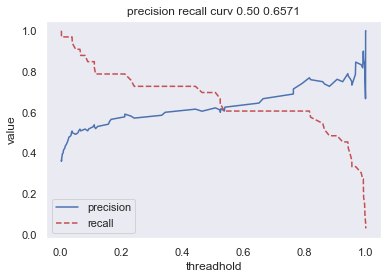

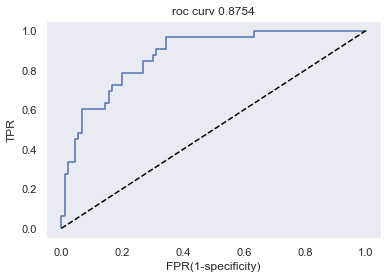

In [ ]:
xgmodel = xgb.XGBClassifier(n_estimators=300, objective="binary:logistic")   #logloss
split_fit_score(scaler_X_train, y_train, xgmodel)   

# 검증
* 교차 검증(cross_val_score) : 데이터 N배 증강시켜 순차적 학습, (점수)
* 폴드(KFold, StratifiedKFold)  : 데이터 N배 증강시켜 순차적 학습, (점수,과정)
* 그리드서치(GridSearch)***   : 데이터 N배 증강시켜 순차적 학습,  (점수, 과정, 모델튜닝)

### 폴드 KFold(), StratifiedKFold()

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

total_score = []

# kfold = KFold(n_splits=5, random_state=1414, shuffle=True)
# for train_index, test_index in kfold.split(문제지):

skfold = StratifiedKFold(n_splits=5, random_state=1414, shuffle=True)
for train_index, test_index in skfold.split(X, y):
    문제지8, 문제지2 = X.iloc[train_index], X.iloc[test_index]
    정답지8, 정답지2 = y.iloc[train_index], y.iloc[test_index]
   #train_test_split(문제지,정답지, test_sizse=0.2, random_state=1414, shuffle=False) ----
    model.fit(문제지8, 정답지8)
    컴퓨터답2 = model.predict(문제지2)
    score = accuracy_score(정답지2, 컴퓨터답2)
    print("fold accuracy:", score)  
    total_score.append(score)
    ####return np.array(total_score)

print("평균", sum(total_score) / len(total_score))
print("평균", np.array(total_score).mean())  #평균 0.8658772599949071

fold accuracy: 0.8181818181818182
fold accuracy: 0.7792207792207793
fold accuracy: 0.7142857142857143
fold accuracy: 0.803921568627451
fold accuracy: 0.6862745098039216
평균 0.7603768780239368
평균 0.7603768780239368


### cross_val_score()

In [ ]:
from sklearn.model_selection import cross_val_score
#scores : ndarray  ::: 위와상동 == np.array(total_score)
total_score = cross_val_score(model, X, y, scoring='accuracy', cv=5)  #n_splits=cv=5
print(total_score)  #평균 0.8658772599949071
print("cross_val_score 평균:", total_score.mean())  #평균 0.867

[0.75974026 0.71428571 0.77272727 0.84313725 0.75163399]
cross_val_score 평균: 0.7683048977166624


### GridSearchCV()
#### <font color=red> [참고] XGBoost로 CV할 경우 : sklean의 estimator가 아니기 때문에 다음과 같이 사용 </font>  

* ref : https://rdrr.io/cran/xgboost/man/xgb.cv.html
* 2020.09.27 기준 : https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/

In [ ]:
dmatrix_df = xgb.DMatrix(data=X, label=y, enable_categorical=True)
xgb_cv_res = xgb.cv(dtrain=dmatrix_df, 
               params={"n_estimators": 300, "objective":"binary:logistic"}, 
               nfold=5, 
               metrics="auc",        #--- 이진분류 점수 중 하나 
               as_pandas=True)
xgb_cv_res['train-auc-mean'].mean()  #------------ 이거 accuracy 점수 아님......

[18:19:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:19:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:19:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used

0.96391206

# 임계치 조정을 통한  f1_score() 올리기

### confusion_matrix 
* ref : https://www.medcalc.org/manual/roc-curves.php
| | |
|:-|:-|
|TN|FP|
|FN|TP|

| | | |
|-|:-|:-|
|정확도|$accuracy=\frac{TN+TP}{TP+FP+FP+FN}$|전체 샘플 중 맞게 예측한 비율|
|정밀도|$precision=\frac{TP}{TP+FP}$|True로 예측한것 중 실제 True인 비율|
|재현률|$recall=\frac{TP}{FN+FP}$|실제 True 중 예측이 True인 비율|
|F1|$f1=2*\frac{precision * recall}{precision + recall}$|정밀도 재현율 조화 평균|

* 재현율(recall) 점수 올리기
<pre>
th:2  --> th:1     [임계치를 낮추면]
[0 1 1]-->[1 1 1]  즉 양성 데이터가 늘었다 --> 24수치를 줄인다
*
[[86 13] <br>
 [24 31]]
</pre>

0
정확도0.3571 정밀도:0.3571 재현률:1.0000 f1:0.5263
오차행렬
 [[ 0 99]
 [ 0 55]]


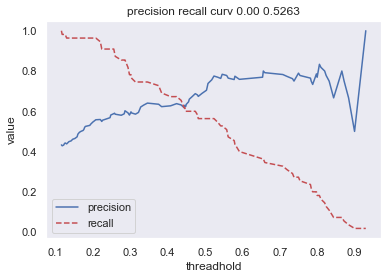

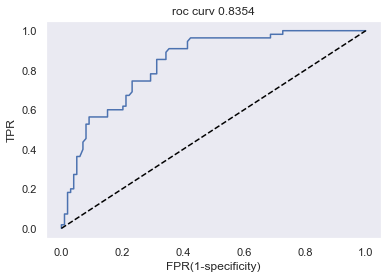

0.35
정확도0.7532 정밀도:0.6349 재현률:0.7273 f1:0.6780
오차행렬
 [[76 23]
 [15 40]]


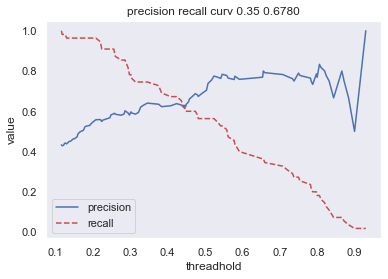

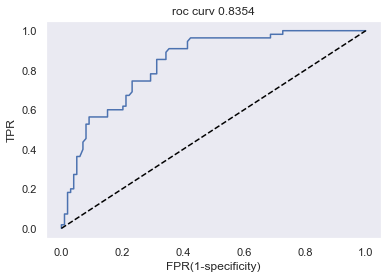

0.38
정확도0.7403 정밀도:0.6230 재현률:0.6909 f1:0.6552
오차행렬
 [[76 23]
 [17 38]]


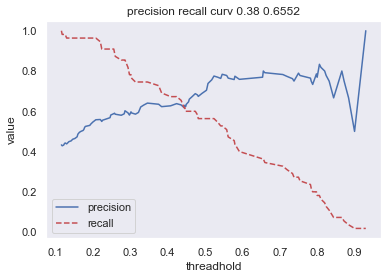

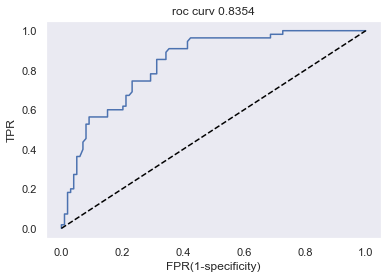

0.42
정확도0.7468 정밀도:0.6379 재현률:0.6727 f1:0.6549
오차행렬
 [[78 21]
 [18 37]]


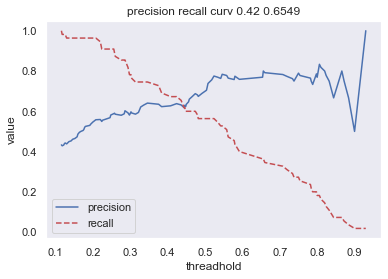

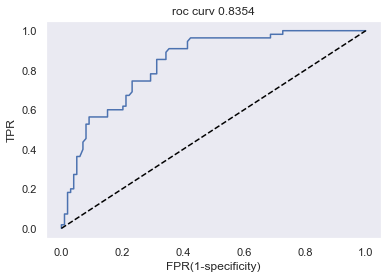

0.45
정확도0.7403 정밀도:0.6471 재현률:0.6000 f1:0.6226
오차행렬
 [[81 18]
 [22 33]]


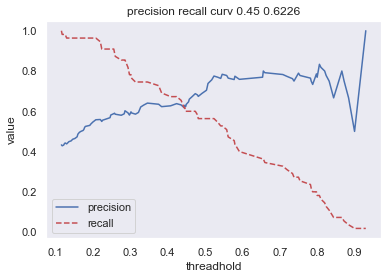

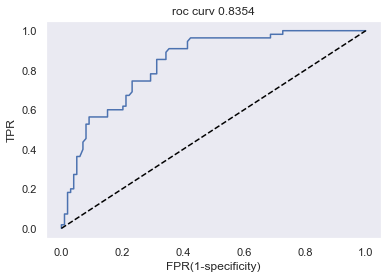

0.5
정확도0.7597 정밀도:0.7045 재현률:0.5636 f1:0.6263
오차행렬
 [[86 13]
 [24 31]]


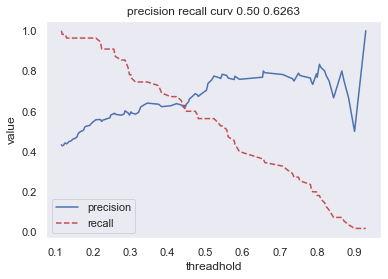

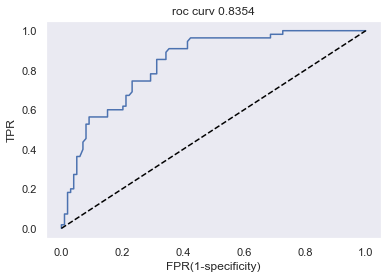

1
정확도0.6429 정밀도:0.0000 재현률:0.0000 f1:0.0000
오차행렬
 [[99  0]
 [55  0]]


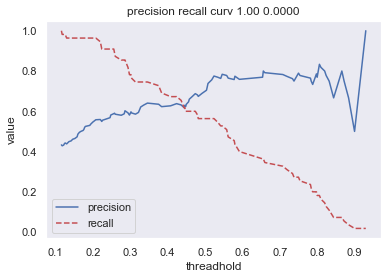

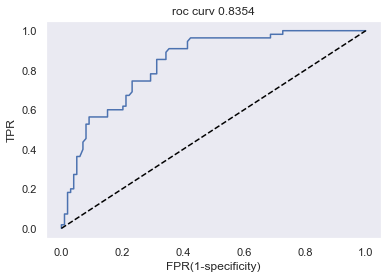

In [ ]:
model = RandomForestClassifier(n_estimators=500,random_state=1414)  #0.7597402597402597
split_fit_score(X,y,model, th_list=1)